- **This code computes the DRTO solution using a scenario-based stochastic programming approach and implements that in the plant.**
- The underlying control structure is modeled using an unconstrained MPC paradigm + disturbance modeling for offset-free performance
- The case study is an affine multiple parallel bioreactor system from:*Gao, Ling. "Modeling and dynamics analyses of immobilized CSTR bioreactor using transfer function model." 2012 International Symposium on Information Technologies in Medicine and Education. Vol. 2. IEEE, 2012.*
- The uncertainty represented by the scenarios comes from the maximum specific growth rate (V_m) --> see matlab file

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: May 2023

In [ ]:
using LinearAlgebra, JuMP, CPLEX, Plots, Distributions, CSV, DataFrames

# Bioreactor Model

$\dfrac{d C}{d t} = D (C_{in} - C) - \dfrac{V_m C}{(K_s + C)} $ <br>
$ \dfrac{d P}{d t} = \dfrac{V_m C}{(K_s + C)} - DP $ <br>

where, <br>
$t$: time in hours \[h\] <br>
$C$: concentration of reactant (substrate) \[g/L\] <br>
$P$: concentration of product (biomass) \[g/L\] <br>
$C_{in}$: inlet concentration of substrate \[g/L\] <br>
$D$: ratio of flowrate to reactor volume \[1/h\] <br>
$V_m$: maximum reaction rate \[g/(h L)\] <br> 
$K_s$: reaction constant \[g/L\] <br>

- System measurement ($y$) - product concentration $P$ <br>
- System inputs ($u$) - inlet reactant concentration $C_{in}$ <br>
- Uncertain parameters ($\theta$) - maximum reaction rate $V_m$

In [2]:
# Sampling time
T = 1 #[h]
# Simulation time in sampling periods
nsim = 20

# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1

# setting bounds (all arbitrary - not in deviation form!!) 
uMax = 5.0 # 1.2
uMin = 0.0;

yspMax = 1.2 
yspMin = 0.0;

# Building CL-DRTO model

## Model linearization
- linearization is done using Matlab's functions ss and c2d (see BioReactorLinearization.m)
- sample time $\Delta t$ is consider as 1h
- linearization around point: $V_m = 0.5$ \[g/(h L)\], $K_s = 0.2$ \[g/L\], $D = 0.5$ \[1/h\], $C_{in,0} = 1$ \[g/L\], $C_{0} = 0.358$ \[g/L\], and $P_{0} = 0.642$ \[g/L\]

which leads to: <br>
$\bar{x}_{k+1} = A \bar{x}_k + B \bar{u}_k$ <br>
$\bar{y}_k = C \bar{u}_k$

where, <br>
$\bar{x} = \begin{bmatrix}
\bar{C}\\
\bar{P}
\end{bmatrix} =
\begin{bmatrix}
C - C_0\\
P - P_0
\end{bmatrix}$<br>
$\bar{u} = \bar{C}_{in} = C_{in} - C_{in,0}$<br>
$\bar{y} = \bar{P} = P - P_0$

In [3]:
# Linearization point
u0 = 1.5
x0 = [0.7179;0.7821]
y0 = 0.7821

# number of reactors in parallel
nReactors = 1
# Number of states
nx = 2*nReactors;

# Possible initial conditions (deviation form)
xInit_0 = repeat([0.3583;0.6418] .- x0, outer = [nReactors,1]);
uInit_0 = 1.0 - u0;

In [4]:
# 100 pre-computed models based on parametric uncertainty Vm (computed using matlab: BioReactorLinearization.m)
bioModels = CSV.read("C:\\Users\\MACC-Jose\\Documents\\GitHub\\BD\\CLDRTO Case Study 2 - Bioreactor\\BioreactorModel", DataFrame; header=false);
#print(bioModels)

CL-DRTO configuration

In [5]:
# DRTO sampling time
nDRTO = 4 # [h]
# Prediction horizon
pD = 20 + (8 - 1) # p = 8 *controller horizon
# Input control horizon 
mD = 20
# Objective function: target tracking (deviation form)
pTrack = 1 - y0 # [g/L]
# Soft upper bounds on P weight (deviation form)
pUB = 1.05 - y0 # [g/L]
# objective function weight for P penalization term 
wP = 100
# number of scenarios 
nScen = 3
# scenario weights (equal probability)
pScen = 1/3;

In [6]:
# picking up indexes equally spaced between 1 and 100 (including initial and end point) 
# based on the desired number of scenarios
indexScen = [floor(Int, 1 + (ii - 1)*(100-1)/(nScen-1)) for ii in 1:nScen]

# building DRTO model
A_drto = Array{Float64}(undef,nx,nx,nScen) 
B_drto = Array{Float64}(undef,nx,nu,nScen) 

for kk in 1:nScen
    
    index_temp = indexScen[kk]
    
    A_drto[:,:,kk] = kron(I(nReactors),Matrix(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,1:2]))
    B_drto[:,:,kk] = repeat(bioModels[2*(index_temp - 1) + 1:2*(index_temp - 1) + 2,3], outer = [nReactors, 1, 1])
    
end

# mapping states to measurements is the same for all models
C_drto = repeat([0 1], outer = [1, nReactors]);

# Building MPC model

Controller configuration

In [9]:
# MPC sampling time
nMPC = 1 # [h]
# Output prediction horizon
p = 8
# Input control horizon 
m = 2
# Output weights
q = 1
# Input weights 
r = 1;

using nominal model(indexScen = 50)

In [10]:
nNom = 50

A = kron(I(nReactors),Matrix(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,1:2])) 
B = repeat(bioModels[2*(nNom - 1) + 1:2*(nNom - 1) + 2,3], outer = [nReactors, 1])
C = repeat([0 1], outer = [1, nReactors]);

## Adding disturbance model

The closed-loop system may never reach the desired controlled variable target if an unmeasured, constant disturbance
enters the process or if model error is present. This problem can be solved by incorporating a constant output disturbance
into the process model: 

$
\begin{vmatrix}
x(k + 1)\\
d(k + 2)
\end{vmatrix}
= 
\begin{vmatrix}
A & 0_{nx,ny}\\
0_{ny,nx} & I_{ny}\\
\end{vmatrix} \ x(k)
\begin{vmatrix}
x(k)\\
d(k)
\end{vmatrix}
+
\begin{vmatrix}
B\\
0_{ny,nu}\end{vmatrix} 
u(k)
$

$
y(k)
= 
\begin{vmatrix}
C & G_p
\end{vmatrix} 
\begin{vmatrix}
x(k)\\
d(k)
\end{vmatrix}
$

in which $d \in \mathcal{R}^{ny}$ is the number of augmented output disturbance states, and $G_p$ determines the effect of these states on the output. In the standard industrial model predictive control implementation, $G_p=I$ and the output
disturbance is estimated as $d_k = y_k - C x_k$.

In [11]:
Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
Bd = [B; zeros(ny,nu)]
Cd = [C ones(ny,ny)];

## Building matrices for MPC


Given the following discrete state-space model:

$ x(k+1) = A_d \ x(k) + B_d \ u(k) $ <br>
$ y(k) = C_d \ x(k)$ <br>

Using the supperposition property of linear systems, we obtain the model outputs from instants $k+1$ to $k+j$ as: <br>
$ y(k + 1|k) = C_d \ x(k + 1|k) = C_dA_d \ x(k) + C_dB_d \ u(k|k)$ <br>
$ y(k + 2|k) = C_dA_d^2 \ x(k) + C_dA_dB_d \ u(k|k) + C_dB_d \ u(k+1|k)$ <br>
$ y(k + 3|k) = C_dA_d^3 \ x(k) + C_dA_d^2B_d \ u(k|k) + C_dA_dB_d \ u(k+1|k) + C_dB_d \ u(k+2|k)$ <br>
$ ... $ <br>
$ y(k + j|k) = C_dA_d^j \ x(k) + C_dA_d^{j-1}B_d \ u(k|k) + C_dA_d^{j-2}B_d \ u(k+1|k) + \cdots + C_dB_d \ u(k + j -1|k)$ 

Suppose now that:<br>
$ u(k + m|k) = u(k + m + 1|k) = \cdots = u(k + p - 1|k)$

The equations above (when $j > m$) can then be re-written as:
$ y(k + m + 1|k) = C_dA_d^{m+1} \ x(k) + C_dA_d^{m}B_d \ u(k|k) + C_dA_d^{m-1}B_d \ u(k+1|k) + \cdots + [C_dA_dB_d + C_dB_d] \ u(k + m -1|k)$ <br>
$ y(k + m + 2|k) = C_dA_d^{m+2} \ x(k) + C_dA_d^{m+1}B_d \ u(k|k) + C_dA_d^{m}B_d \ u(k+1|k) + \cdots + [C_dA_d^2B_d + C_dA_dB_d + C_dB_d] \ u(k + m -1|k)$ <br>
$ ... $ <br>
$ y(k + pk) = C_dA_d^{p} \ x(k) + C_dA_d^{p-1}B_d \ u(k|k) + C_dA_d^{p-2}B_d \ u(k+1|k) + \cdots + [C_dA_d^{p-m}B_d + C_dA_d^{p-m-1}B_d + \cdots + C_dB_d] \ u(k + m -1|k)$

Thus, the vector of output predictions can be written as follows:

$
\begin{vmatrix}
y(k + 1|k)\\
y(k + 2|k)\\
\vdots \\
y(k + m|k) \\
y(k + m + 1|k)\\ 
\vdots \\
y(k + p|k)
\end{vmatrix}
= 
\begin{vmatrix}
C_dA_d\\
C_dA_d^{2}\\
\vdots \\
C_dA_d^{m} \\
C_dA_d^{m+1}\\ 
\vdots \\
C_dA_d^{p}
\end{vmatrix} \ x(k)
+
\begin{vmatrix}
C_dB_d          & 0               & \cdots & 0\\
C_dA_dB_d       & C_dB_d          & \cdots & 0\\
\vdots          & \vdots          & \cdots & \vdots\\
C_dA_d^{m-1}B_d & C_dA_d^{m-2}B_d & \cdots & C_dB_d\\
C_dA_d^{m}B_d   & C_dA_d^{m-1}B_d & \cdots & C_d\tilde{A}_{d,1}B_d\\ 
\vdots          & \vdots          & \cdots & \vdots\\
C_dA_d^{p-1}B_d & C_dA_d^{p-2}B_d & \cdots & C_d\tilde{A}_{d,p-m}B_d
\end{vmatrix} 
\begin{vmatrix}
u(k|k)\\
u(k + 2|k)\\
\vdots \\
u(k + m - 1|k) 
\end{vmatrix}
$

where: <br>
$\tilde{A}_{d,1} = A_d + I, \quad \tilde{A}_{d,2} = A_d^2 + A_d + I, \quad \tilde{A}_{d,p-m} = A_d^{p-m} + A_d^{p-m-1} + \cdots + I$

Simpifying, we have: <br>
$ \bar{y}(k) = \Psi \ x(k) + \Theta \ u(k) $ 

In [12]:
Psi = Cd*Ad
for ii in 2:p
    Psi = [Psi;  Cd*Ad^ii]
end

# Computing Dynamic Matrix
a = Cd*Bd
for ii in 2:p
    a = [a; Cd*Ad^(ii - 1)*Bd]
end
DynM = a

for ii in 1:(m - 2)
    a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
    DynM = [DynM  a]
end

# adjusting dynamic matrix for since p > m (last column)
b = Cd*Bd

Ai = I(nx+1) # adding disturbance to the states
for ii = 1:(p - m)
    Ai = Ai + Ad^ii
    b = [b;Cd*Ai*Bd]
end

Theta=[DynM [zeros(ny*(m-1),nu);b]];

The first term (output tracking) of the MPC objective function is: 

$ \sum_{j=1}^p (y(k + j|k) - y^{SP})^T \ Q \ (y(k + j|k) - y^{SP}) $

which can be written as:

$ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) $

where: 
$ \bar{Q} = diag\bigg( Q, \cdots, Q\bigg)$ - $p$ repetitions of $Q$

The second term (inputs movement penalization) of the MPC objective function is: 

$ \sum_{j=1}^{m-1} \Delta u(k + j|k)^T \ R \ \Delta u(k + j|k) $

We observe that:
$
\begin{vmatrix}
\Delta u(k|k)\\
\Delta u(k + 1|k)\\
\vdots \\
\Delta u(k + m - 1|k) 
\end{vmatrix}
= 
\begin{vmatrix}
u(k|k) - u(k - 1)\\
u(k + 1|k) - u(k|k)\\
\vdots \\
u(k + m - 1|k) - u(k + m - 2|k)
\end{vmatrix}
=
u_k - Mu_k - \bar{I} u(k - 1)
= (I_{nu,m} - M)u_k - \bar{I} u(k - 1)
= I_M u_k - \bar{I} u(k - 1)
$

in which:
$
M = 
\begin{vmatrix}
0_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
I_{nu} & 0_{nu} & \cdots & 0_{nu} & 0_{nu}\\
0_{nu} & I_{nu} & \cdots & 0_{nu} & 0_{nu}\\
\vdots & \vdots & \cdots & \vdots & \vdots\\
0_{nu} & 0_{nu} & \cdots & I_{nu} & 0_{nu}
\end{vmatrix}, \quad
\bar{I} = 
\begin{vmatrix}
I_{nu}\\
0_{nu}\\
0_{nu}\\
\vdots\\
0_{nu}
\end{vmatrix}
$

the second term can be written as:

$ (I_M u_k - \bar{I} u(k - 1))^T \ \bar{R} \ (I_M u_k - \bar{I} u(k - 1)) $

where: 
$ \bar{R} = diag\bigg( R, \cdots, R\bigg)$ - $m$ repetitions of $R$

In [13]:
# Creating Qbar and Rbar matrices
Qbar = Diagonal([q for ii in 1:p])
Rbar = Diagonal([r for ii in 1:m])

# Creating input movement OF penalty matrix 
M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
Ibar=[I(nu); zeros(nu*(m-1),nu)]
IM = I(nu*m) - M';

The objective function then can be reduced to a quadratic function of the form:
$$ J_k = u_k^T \ H \ u_k + 2c_f^T \ u_k + c $$

where:

$H = \Theta^T \ \bar{Q} \ \Theta + I_M^T \ \bar{R} \ I_M$ <br>
$c_f^T = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ \Theta + u(k-1)^T\bar{I}^T \ \bar{R} \ I_M$ <br>
$c = (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP})^T \ \bar{Q} \ (\Psi \ x(k) + \Theta \ u(k) - \bar{y}^{SP}) + u(k-1)^T\bar{I}^T \ \bar{R} \ \bar{I} \ u(k-1)$

In [14]:
# Matrix H
H = Theta'*Qbar*Theta + IM'*Rbar*IM;

## Unconstrained MPC solution
the FOC of the unconstrained MPC problem is:

$$ \dfrac{\partial J_k}{\partial u_k}\bigg|_{u_k^\star} = 2 \ u_k^{\star,T} \ H + 2c_f^T = 0 $$ 
 
Hence: 

$$ \ u_k^{\star,T} \ H + c_f^T = 0 $$ 
$$ \ u_k^{\star,T} \ H = - c_f^T $$ 

Transposing both sides ($H$ is symmetric, $H^T = H$):

$$ H \ u_k^{\star} = - c_f $$ 

# Building function to solve CL-DRTO using MSS framework

$ \min_{\boldsymbol{y}^{SP}} \quad \Phi^{ECO}(\boldsymbol{x},\boldsymbol{y},\boldsymbol{u}) $ <br>

subjected to: ($k$ represents time and $s$ scenarios) <br>

For each scenario ($s = 1,\ldots,n^{scen}$) <br>
>    System dynamics <br>
>    $\boldsymbol{x}_{k + 1,s} = A\boldsymbol{x}_{k,s} + B_s\boldsymbol{u}_{k,s} $ <br>
>    $\boldsymbol{y}_{k,s} = C\boldsymbol{x}_{k,s}$

>    CL-DRTO control horizon: constraints fixing inputs after horizon ends <br>
>    $\boldsymbol{u}_{k,s} - \boldsymbol{u}_{k - 1,s} = 0, \quad k = m^{DRTO} + 1,\ldots,p^{DRTO}$

>    $\Delta u$ constraints (N.B.: $\boldsymbol{u}_{0}$ comes from the plant and it is the same for all scenarios) <br>
>    $-\Delta \boldsymbol{u}_{max} \leq \boldsymbol{u}_{k,s} - \boldsymbol{u}_{k-1,s} \leq \Delta \boldsymbol{u}_{max}, \quad k = 1,\ldots,m^{DRTO}$

>    Product quality target band <br>
>    $\boldsymbol{y}_{k,s} + \boldsymbol{\delta}^p_{k,s} \geq \boldsymbol{y}_{target,lb}$ <br>
>    $\boldsymbol{y}_{k,s} - \boldsymbol{\delta}^m_{k,s} \leq \boldsymbol{y}_{target,ub}$

>    Unconstrained MPC (MPC model is fixed and equal to nominal model)<br>
>    $H \ \boldsymbol{U}_{k,s} - c_f = 0$<br>
>    $\text{where} \quad c_f = f(\boldsymbol{x}_{k,s},\boldsymbol{u}_{k-1,s},\boldsymbol{Y}^{SP}_{k,s})$ <br>
>    $ \quad \quad \quad \boldsymbol{U}_{k,s} = [\boldsymbol{u}^{1}_{k,s},\boldsymbol{u}^{2}_{k,s},\ldots,\boldsymbol{u}^{m}_{k,s}]$<br>
>    $\quad \quad \quad \boldsymbol{Y}^{SP}_{k,s} = [\boldsymbol{y}^{SP}_{k,s},\ldots,\boldsymbol{y}^{SP}_{k,s}] \quad$    ($p$ repetitions of $\boldsymbol{y}^{SP}_{k,s}$)<br>

Non-antecipativity constraints <br>
$\boldsymbol{y}^{SP}_{k,s} = \boldsymbol{y}^{SP}_{k,S}, \quad k = 1,\ldots,\Delta t_{DRTO} \ \quad s = 1,\ldots,S - 1,S + 1,\ldots,n^{scen}$

Variable bounds <br>
$\forall k, \forall s \quad \boldsymbol{x}_{k,s} \in \mathcal{X}, \ \boldsymbol{u}_{k,s} \in \mathcal{U}, \ \boldsymbol{y}_{k,s} \in \mathcal{Y}, \ \boldsymbol{y}^{SP}_{k,s} \in \mathcal{Y}^{SP}$



In [30]:
## Modeling the sub problem (scenario) -- modeling inside a function
function MS_CLDRTO(xInit,uInit,nScen,pScen,pTrack,pUB)

    # Define our model
    model_ms = Model(CPLEX.Optimizer)
    #set_optimizer_attribute(model_ms, "CPXPARAM_ScreenOutput"=false)
    # set_optimizer_attribute(m, "warm_start_init_point", "yes")
    set_silent(model_ms) # avoid printing
    
    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, xDRTO[1:pD,1:nx,1:nScen])
    @variable(model_ms, yDRTO[1:pD,1:nScen])
    
    # MPC model variables
    @variable(model_ms, xMPC[1:pD,1:nx,1:nScen])
    @variable(model_ms, yMPC[1:pD,1:nScen])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:pD,1:nScen])
    
    # inputs computed by MPCs
    @variable(model_ms, (uMin - u0) <= u[1:pD,1:m,1:nScen] <= (uMax - u0))
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, (yspMin - y0) <= ysp[1:pD,1:nScen] <= (yspMax - y0))
    
    # slacks for P soft constraint
    @variable(model_ms, delta_p[1:pD,1:nScen] ≥ 0)

    #############################
    # Set up objective function #
    #############################
    # track p with penalization for soft constraint P
    @objective(model_ms, Min, pScen*sum((yDRTO[kk,ss] - pTrack)^2 + wP*delta_p[kk,ss]^2 for kk in 1:pD, ss in 1:nScen))

    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(model_ms, CLDRTO_dyn_model_1[ss=1:nScen], xDRTO[1,:,ss] .== A_drto[:,:,ss]*xInit + B_drto[:,:,ss]*uInit)
    @constraint(model_ms, CLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], xDRTO[kk + 1,:,ss] .== A_drto[:,:,ss]*xDRTO[kk,:,ss] + B_drto[:,:,ss]*u[kk,1,ss])
    @constraint(model_ms, CLDRTO_model_out[kk=1:pD,ss=1:nScen], yDRTO[kk,ss] == dot(C_drto,xDRTO[kk,:,ss]))
    
    # Model Dynamic for Controller
    @constraint(model_ms, MPC_dyn_model_1[ss=1:nScen], xMPC[1,:,ss] .== A*xInit + B*uInit)
    @constraint(model_ms, MPC_dyn_model[kk=1:(pD - 1),ss=1:nScen], xMPC[kk + 1,:,ss] .== A*xMPC[kk,:,ss] + B*u[kk,1,ss])
    @constraint(model_ms, MPC_model_out[kk=1:pD,ss=1:nScen], yMPC[kk,ss] == dot(C,xMPC[kk,:,ss]))    
    
    #  Model deviation
    @constraint(model_ms, MPC_model_dev[kk=1:pD,ss=1:nScen], de[kk,ss] == yDRTO[kk,ss] - yMPC[kk,ss])
    
    # fixing setpoint changes after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,:,ss] .== u[mD,:,ss])
    
    # ysp in target
    @constraint(model_ms, soft_P[kk=1:pD,ss=1:nScen], yDRTO[kk] - delta_p[kk] <= pUB)
    
    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], ysp[kk,1] - ysp[kk,ss] == 0.0);
    
    ################
    # MPC solution #
    ################ 
    @expression(model_ms, cfT_1[ss=1:nScen], (Psi*[xMPC[1,:,ss];de[1,ss]] - ysp[1:p,ss])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(model_ms, cfT[kk=2:mD,ss=1:nScen], (Psi*[xMPC[kk,:,ss];de[kk,ss]] - ysp[kk:(kk + p - 1),ss])'*Qbar*Theta - u[kk-1,1,ss]'*Ibar'*Rbar*IM)

        # Unconstrained MPC solution
        @constraint(model_ms, MPC_sol_1[ss=1:nScen], H*u[1,:,ss] + cfT_1[ss]' .== 0)
        @constraint(model_ms, MPC_sol[kk=2:mD,ss=1:nScen], H*u[kk,:,ss] + cfT[kk,ss]' .== 0)
    

    # @show model_ms
    
    optimize!(model_ms)
    flag = termination_status(model_ms)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(model_ms)
    uArray = value.(u)
    yArray = value.(yDRTO)
    yspArray = value.(ysp)
    slackArray = value.(delta_p)
    
    # all_con = all_constraints(model_ms, AffExpr, MOI.EqualTo{Float64})
    λ = dual.(nonAnt)
    
    return Dict('o' => o, 'f' => flag, 'λ' => λ, 'u' => uArray, 'y' => yArray, 'p' => slackArray,'d'=>yspArray)
end;

Solve Model

In [31]:
# Solve the model
solDict = MS_CLDRTO(xInit_0,uInit_0,nScen,pScen,pTrack,pUB);

In [18]:
solDict['f']

OPTIMAL::TerminationStatusCode = 1

Preparing for plotting

In [19]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

# Extracting solution for plotting
yTraj_ms = Array{Float64}(undef,pD,nScen)
uTraj_ms = Matrix{Float64}(undef,pD,nScen) 
yspTraj_ms = Matrix{Float64}(undef,pD,nScen) 

for i in 1:pD
    for s in 1:nScen
        yTraj_ms[i,s] = solDict['y'][i,s] + y0
        yspTraj_ms[i,s] = solDict['d'][i,s] + y0
        uTraj_ms[i,s] = solDict['u'][i,1,s] + u0
    end
end;

#display(solDict['d'][1,1])
#display(solDict['d'][1,2])
#display(solDict['d'][1,3])

Plot

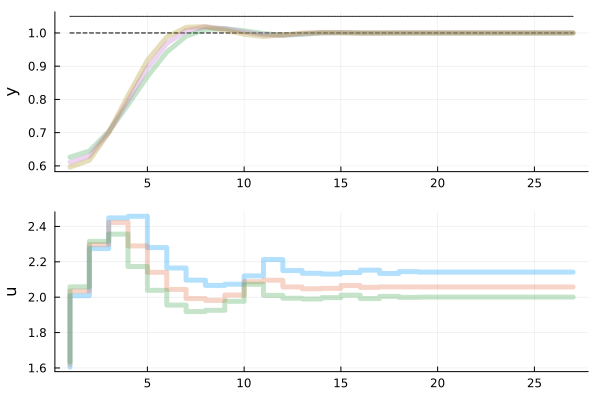

In [22]:
gr()

p1 = plot(ts,(pUB + y0)*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,(pTrack + y0)*ones(length(ts)),linestyle = :dash,linecolor = :black)

for ss = 1:nScen
    if ss == 1 # adding legend
        p1 = plot!(ts,yTraj_ms[:,ss],linewidth=5,yaxis="y",linealpha = 0.3)
    else
        p1 = plot!(ts,yTraj_ms[:,ss],linewidth=5,linealpha = 0.3,legend=false)
    end
end
    
p1.series_list[1][:label] = "yt"
p1.series_list[2][:label] = "y1"
p1.series_list[3][:label] = "y2"
p1.series_list[4][:label] = "y3"

#p2 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black)
for ss = 1:nScen
    if ss == 1 # adding legend
        p2 = plot(ts,uTraj_ms[:,ss],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3)
    else
        p2 = plot!(ts,uTraj_ms[:,ss],linewidth=5,linetype=:steppre,linealpha = 0.3,legend=false)
    end
end

g1 = plot(p1,p2,layout=(2,1))
display(g1)

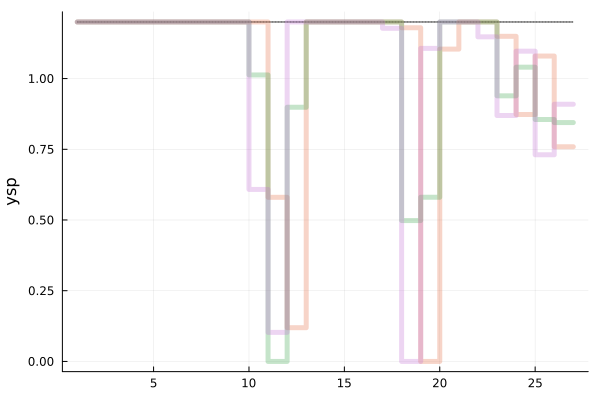

In [21]:
gr()

p3 = plot(ts,yspMax*ones(length(ts)),linestyle = :dot,linecolor = :black)
for ss = 1:nScen
    if ss == 1 # adding legend
        p3 = plot!(ts,yspTraj_ms[:,ss],linewidth=5,linetype=:steppre,yaxis="ysp",linealpha = 0.3)
    else
        p3 = plot!(ts,yspTraj_ms[:,ss],linewidth=5,linetype=:steppre,linealpha = 0.3,legend=false)
    end
end

p3.series_list[1][:label] = "y_bound"
p3.series_list[2][:label] = "ycl"

display(p3)

# Implementing MS-CL-DRTO in closed loop with the plant

Here we run a Monte Carlo Analysis of the DRTO results. The plant gain is drawn at each MC iteration and the DRTO has access to the lower and upper bound of that distribution 

In [44]:
# Monte Carlo iterations
nMC_imp = 50 # 1 | 10

# Simulation time in sampling periods
nsim = 100

# time series for plotting
xPlant_ol_ms = Array{Float64}(undef,nx,nsim,nMC_imp) 
xModel_ol_ms = Array{Float64}(undef,nx,nsim,nMC_imp) 
uPlant_ol_ms = Matrix{Float64}(undef,nsim,nMC_imp) 
yPlant_ol_ms = Matrix{Float64}(undef,nsim,nMC_imp) 
yModel_ol_ms = Matrix{Float64}(undef,nsim,nMC_imp) 
dev_ol_ms = Matrix{Float64}(undef,nsim,nMC_imp) 

for jj = 1:nMC_imp
    
    # drawing random number to choose the scenario
    scenSim = rand(1:100)
    
    # Plant model
    Ap = kron(I(nReactors),Matrix(bioModels[2*(scenSim - 1) + 1:2*(scenSim - 1) + 2,1:2]))
    Bp = repeat(bioModels[2*(scenSim - 1) + 1:2*(scenSim - 1) + 2,3], outer = [nReactors, 1, 1])
    Cp = repeat([0 1], outer = [1, nReactors])
    
    # initializing simulation
    xmk = xInit_0 # model 
    xpk = xInit_0 # plant
    uk_1 = uInit_0
    ypk = dot(Cp,xInit_0)
    ymk = dot(C,xInit_0)
    
    # initial state is known 
    dek = ypk - ymk

    # RUNNING SIMULATION
    for ii = 1:nsim
        
        print("MC: ", jj)
        println(">> Time: ",ii)

        # updating arrays
        xPlant_ol_ms[:,ii,jj] = xpk 
        xModel_ol_ms[:,ii,jj] = xmk
        uPlant_ol_ms[ii,jj] = uk_1 + u0
        yPlant_ol_ms[ii,jj] = ypk + y0
        yModel_ol_ms[ii,jj] = ymk + y0
        dev_ol_ms[ii,jj] = dek
        
        # executing DRTO
        if ii%nDRTO == 0 || ii == 1
            global sol_k = MS_CLDRTO(xpk,uk_1,nScen,pScen,pTrack,pUB);
            # counter for DRTO executions
            global countDRTO = 1;
            # N.B. need to declare as global due to loop scope
            
        end
        
        # Preparing controller 
        # building terms of the OF that depend on current information
        yspk = sol_k['y'][countDRTO:countDRTO + p - 1,1]
        countDRTO += 1;
        # use an arbitrary scenario (WRONG! But it is used to build the template for CL-DRTO)
        # computing deviation
                        
        # computing auxiliary term
        cf_T = (Psi*[xmk;dek] - yspk)'*Qbar*Theta - uk_1'*Ibar'*Rbar*IM
           
        # solving linear system
        ukk = H\-cf_T'

        # extracting the first input
        uk = ukk[1]
       
        # applying input to the plant
        xpk = Ap*xpk + Bp*uk
        xpk = convert(Matrix{Float64}, xpk[:,:,1])
        ypk = dot(Cp,xpk) 
        

        # applying input to the controller model
        xmk = Matrix(A*xmk + B*uk)
        ymk = dot(C,xmk)

        # computing disturbance model
        dek = ypk - ymk

            # loop
            uk_1 = uk

    end
end

MC: 1>> Time: 1
MC: 1>> Time: 2
MC: 1>> Time: 3
MC: 1>> Time: 4
MC: 1>> Time: 5
MC: 1>> Time: 6
MC: 1>> Time: 7
MC: 1>> Time: 8
MC: 1>> Time: 9
MC: 1>> Time: 10
MC: 1>> Time: 11
MC: 1>> Time: 12
MC: 1>> Time: 13
MC: 1>> Time: 14
MC: 1>> Time: 15
MC: 1>> Time: 16
MC: 1>> Time: 17
MC: 1>> Time: 18
MC: 1>> Time: 19
MC: 1>> Time: 20
MC: 1>> Time: 21
MC: 1>> Time: 22
MC: 1>> Time: 23
MC: 1>> Time: 24
MC: 1>> Time: 25
MC: 1>> Time: 26
MC: 1>> Time: 27
MC: 1>> Time: 28
MC: 1>> Time: 29
MC: 1>> Time: 30
MC: 1>> Time: 31
MC: 1>> Time: 32
MC: 1>> Time: 33
MC: 1>> Time: 34
MC: 1>> Time: 35
MC: 1>> Time: 36
MC: 1>> Time: 37
MC: 1>> Time: 38
MC: 1>> Time: 39
MC: 1>> Time: 40
MC: 1>> Time: 41
MC: 1>> Time: 42
MC: 1>> Time: 43
MC: 1>> Time: 44
MC: 1>> Time: 45
MC: 1>> Time: 46
MC: 1>> Time: 47
MC: 1>> Time: 48
MC: 1>> Time: 49
MC: 1>> Time: 50
MC: 1>> Time: 51
MC: 1>> Time: 52
MC: 1>> Time: 53
MC: 1>> Time: 54
MC: 1>> Time: 55
MC: 1>> Time: 56
MC: 1>> Time: 57
MC: 1>> Time: 58
MC: 1>> Time: 59
MC: 1>

MC: 5>> Time: 89
MC: 5>> Time: 90
MC: 5>> Time: 91
MC: 5>> Time: 92
MC: 5>> Time: 93
MC: 5>> Time: 94
MC: 5>> Time: 95
MC: 5>> Time: 96
MC: 5>> Time: 97
MC: 5>> Time: 98
MC: 5>> Time: 99
MC: 5>> Time: 100
MC: 6>> Time: 1
MC: 6>> Time: 2
MC: 6>> Time: 3
MC: 6>> Time: 4
MC: 6>> Time: 5
MC: 6>> Time: 6
MC: 6>> Time: 7
MC: 6>> Time: 8
MC: 6>> Time: 9
MC: 6>> Time: 10
MC: 6>> Time: 11
MC: 6>> Time: 12
MC: 6>> Time: 13
MC: 6>> Time: 14
MC: 6>> Time: 15
MC: 6>> Time: 16
MC: 6>> Time: 17
MC: 6>> Time: 18
MC: 6>> Time: 19
MC: 6>> Time: 20
MC: 6>> Time: 21
MC: 6>> Time: 22
MC: 6>> Time: 23
MC: 6>> Time: 24
MC: 6>> Time: 25
MC: 6>> Time: 26
MC: 6>> Time: 27
MC: 6>> Time: 28
MC: 6>> Time: 29
MC: 6>> Time: 30
MC: 6>> Time: 31
MC: 6>> Time: 32
MC: 6>> Time: 33
MC: 6>> Time: 34
MC: 6>> Time: 35
MC: 6>> Time: 36
MC: 6>> Time: 37
MC: 6>> Time: 38
MC: 6>> Time: 39
MC: 6>> Time: 40
MC: 6>> Time: 41
MC: 6>> Time: 42
MC: 6>> Time: 43
MC: 6>> Time: 44
MC: 6>> Time: 45
MC: 6>> Time: 46
MC: 6>> Time: 47
MC: 6

MC: 10>> Time: 73
MC: 10>> Time: 74
MC: 10>> Time: 75
MC: 10>> Time: 76
MC: 10>> Time: 77
MC: 10>> Time: 78
MC: 10>> Time: 79
MC: 10>> Time: 80
MC: 10>> Time: 81
MC: 10>> Time: 82
MC: 10>> Time: 83
MC: 10>> Time: 84
MC: 10>> Time: 85
MC: 10>> Time: 86
MC: 10>> Time: 87
MC: 10>> Time: 88
MC: 10>> Time: 89
MC: 10>> Time: 90
MC: 10>> Time: 91
MC: 10>> Time: 92
MC: 10>> Time: 93
MC: 10>> Time: 94
MC: 10>> Time: 95
MC: 10>> Time: 96
MC: 10>> Time: 97
MC: 10>> Time: 98
MC: 10>> Time: 99
MC: 10>> Time: 100
MC: 11>> Time: 1
MC: 11>> Time: 2
MC: 11>> Time: 3
MC: 11>> Time: 4
MC: 11>> Time: 5
MC: 11>> Time: 6
MC: 11>> Time: 7
MC: 11>> Time: 8
MC: 11>> Time: 9
MC: 11>> Time: 10
MC: 11>> Time: 11
MC: 11>> Time: 12
MC: 11>> Time: 13
MC: 11>> Time: 14
MC: 11>> Time: 15
MC: 11>> Time: 16
MC: 11>> Time: 17
MC: 11>> Time: 18
MC: 11>> Time: 19
MC: 11>> Time: 20
MC: 11>> Time: 21
MC: 11>> Time: 22
MC: 11>> Time: 23
MC: 11>> Time: 24
MC: 11>> Time: 25
MC: 11>> Time: 26
MC: 11>> Time: 27
MC: 11>> Time: 28


MC: 15>> Time: 37
MC: 15>> Time: 38
MC: 15>> Time: 39
MC: 15>> Time: 40
MC: 15>> Time: 41
MC: 15>> Time: 42
MC: 15>> Time: 43
MC: 15>> Time: 44
MC: 15>> Time: 45
MC: 15>> Time: 46
MC: 15>> Time: 47
MC: 15>> Time: 48
MC: 15>> Time: 49
MC: 15>> Time: 50
MC: 15>> Time: 51
MC: 15>> Time: 52
MC: 15>> Time: 53
MC: 15>> Time: 54
MC: 15>> Time: 55
MC: 15>> Time: 56
MC: 15>> Time: 57
MC: 15>> Time: 58
MC: 15>> Time: 59
MC: 15>> Time: 60
MC: 15>> Time: 61
MC: 15>> Time: 62
MC: 15>> Time: 63
MC: 15>> Time: 64
MC: 15>> Time: 65
MC: 15>> Time: 66
MC: 15>> Time: 67
MC: 15>> Time: 68
MC: 15>> Time: 69
MC: 15>> Time: 70
MC: 15>> Time: 71
MC: 15>> Time: 72
MC: 15>> Time: 73
MC: 15>> Time: 74
MC: 15>> Time: 75
MC: 15>> Time: 76
MC: 15>> Time: 77
MC: 15>> Time: 78
MC: 15>> Time: 79
MC: 15>> Time: 80
MC: 15>> Time: 81
MC: 15>> Time: 82
MC: 15>> Time: 83
MC: 15>> Time: 84
MC: 15>> Time: 85
MC: 15>> Time: 86
MC: 15>> Time: 87
MC: 15>> Time: 88
MC: 15>> Time: 89
MC: 15>> Time: 90
MC: 15>> Time: 91
MC: 15>> T

MC: 19>> Time: 100
MC: 20>> Time: 1
MC: 20>> Time: 2
MC: 20>> Time: 3
MC: 20>> Time: 4
MC: 20>> Time: 5
MC: 20>> Time: 6
MC: 20>> Time: 7
MC: 20>> Time: 8
MC: 20>> Time: 9
MC: 20>> Time: 10
MC: 20>> Time: 11
MC: 20>> Time: 12
MC: 20>> Time: 13
MC: 20>> Time: 14
MC: 20>> Time: 15
MC: 20>> Time: 16
MC: 20>> Time: 17
MC: 20>> Time: 18
MC: 20>> Time: 19
MC: 20>> Time: 20
MC: 20>> Time: 21
MC: 20>> Time: 22
MC: 20>> Time: 23
MC: 20>> Time: 24
MC: 20>> Time: 25
MC: 20>> Time: 26
MC: 20>> Time: 27
MC: 20>> Time: 28
MC: 20>> Time: 29
MC: 20>> Time: 30
MC: 20>> Time: 31
MC: 20>> Time: 32
MC: 20>> Time: 33
MC: 20>> Time: 34
MC: 20>> Time: 35
MC: 20>> Time: 36
MC: 20>> Time: 37
MC: 20>> Time: 38
MC: 20>> Time: 39
MC: 20>> Time: 40
MC: 20>> Time: 41
MC: 20>> Time: 42
MC: 20>> Time: 43
MC: 20>> Time: 44
MC: 20>> Time: 45
MC: 20>> Time: 46
MC: 20>> Time: 47
MC: 20>> Time: 48
MC: 20>> Time: 49
MC: 20>> Time: 50
MC: 20>> Time: 51
MC: 20>> Time: 52
MC: 20>> Time: 53
MC: 20>> Time: 54
MC: 20>> Time: 55


MC: 24>> Time: 61
MC: 24>> Time: 62
MC: 24>> Time: 63
MC: 24>> Time: 64
MC: 24>> Time: 65
MC: 24>> Time: 66
MC: 24>> Time: 67
MC: 24>> Time: 68
MC: 24>> Time: 69
MC: 24>> Time: 70
MC: 24>> Time: 71
MC: 24>> Time: 72
MC: 24>> Time: 73
MC: 24>> Time: 74
MC: 24>> Time: 75
MC: 24>> Time: 76
MC: 24>> Time: 77
MC: 24>> Time: 78
MC: 24>> Time: 79
MC: 24>> Time: 80
MC: 24>> Time: 81
MC: 24>> Time: 82
MC: 24>> Time: 83
MC: 24>> Time: 84
MC: 24>> Time: 85
MC: 24>> Time: 86
MC: 24>> Time: 87
MC: 24>> Time: 88
MC: 24>> Time: 89
MC: 24>> Time: 90
MC: 24>> Time: 91
MC: 24>> Time: 92
MC: 24>> Time: 93
MC: 24>> Time: 94
MC: 24>> Time: 95
MC: 24>> Time: 96
MC: 24>> Time: 97
MC: 24>> Time: 98
MC: 24>> Time: 99
MC: 24>> Time: 100
MC: 25>> Time: 1
MC: 25>> Time: 2
MC: 25>> Time: 3
MC: 25>> Time: 4
MC: 25>> Time: 5
MC: 25>> Time: 6
MC: 25>> Time: 7
MC: 25>> Time: 8
MC: 25>> Time: 9
MC: 25>> Time: 10
MC: 25>> Time: 11
MC: 25>> Time: 12
MC: 25>> Time: 13
MC: 25>> Time: 14
MC: 25>> Time: 15
MC: 25>> Time: 16


MC: 29>> Time: 29
MC: 29>> Time: 30
MC: 29>> Time: 31
MC: 29>> Time: 32
MC: 29>> Time: 33
MC: 29>> Time: 34
MC: 29>> Time: 35
MC: 29>> Time: 36
MC: 29>> Time: 37
MC: 29>> Time: 38
MC: 29>> Time: 39
MC: 29>> Time: 40
MC: 29>> Time: 41
MC: 29>> Time: 42
MC: 29>> Time: 43
MC: 29>> Time: 44
MC: 29>> Time: 45
MC: 29>> Time: 46
MC: 29>> Time: 47
MC: 29>> Time: 48
MC: 29>> Time: 49
MC: 29>> Time: 50
MC: 29>> Time: 51
MC: 29>> Time: 52
MC: 29>> Time: 53
MC: 29>> Time: 54
MC: 29>> Time: 55
MC: 29>> Time: 56
MC: 29>> Time: 57
MC: 29>> Time: 58
MC: 29>> Time: 59
MC: 29>> Time: 60
MC: 29>> Time: 61
MC: 29>> Time: 62
MC: 29>> Time: 63
MC: 29>> Time: 64
MC: 29>> Time: 65
MC: 29>> Time: 66
MC: 29>> Time: 67
MC: 29>> Time: 68
MC: 29>> Time: 69
MC: 29>> Time: 70
MC: 29>> Time: 71
MC: 29>> Time: 72
MC: 29>> Time: 73
MC: 29>> Time: 74
MC: 29>> Time: 75
MC: 29>> Time: 76
MC: 29>> Time: 77
MC: 29>> Time: 78
MC: 29>> Time: 79
MC: 29>> Time: 80
MC: 29>> Time: 81
MC: 29>> Time: 82
MC: 29>> Time: 83
MC: 29>> T

MC: 33>> Time: 93
MC: 33>> Time: 94
MC: 33>> Time: 95
MC: 33>> Time: 96
MC: 33>> Time: 97
MC: 33>> Time: 98
MC: 33>> Time: 99
MC: 33>> Time: 100
MC: 34>> Time: 1
MC: 34>> Time: 2
MC: 34>> Time: 3
MC: 34>> Time: 4
MC: 34>> Time: 5
MC: 34>> Time: 6
MC: 34>> Time: 7
MC: 34>> Time: 8
MC: 34>> Time: 9
MC: 34>> Time: 10
MC: 34>> Time: 11
MC: 34>> Time: 12
MC: 34>> Time: 13
MC: 34>> Time: 14
MC: 34>> Time: 15
MC: 34>> Time: 16
MC: 34>> Time: 17
MC: 34>> Time: 18
MC: 34>> Time: 19
MC: 34>> Time: 20
MC: 34>> Time: 21
MC: 34>> Time: 22
MC: 34>> Time: 23
MC: 34>> Time: 24
MC: 34>> Time: 25
MC: 34>> Time: 26
MC: 34>> Time: 27
MC: 34>> Time: 28
MC: 34>> Time: 29
MC: 34>> Time: 30
MC: 34>> Time: 31
MC: 34>> Time: 32
MC: 34>> Time: 33
MC: 34>> Time: 34
MC: 34>> Time: 35
MC: 34>> Time: 36
MC: 34>> Time: 37
MC: 34>> Time: 38
MC: 34>> Time: 39
MC: 34>> Time: 40
MC: 34>> Time: 41
MC: 34>> Time: 42
MC: 34>> Time: 43
MC: 34>> Time: 44
MC: 34>> Time: 45
MC: 34>> Time: 46
MC: 34>> Time: 47
MC: 34>> Time: 48


MC: 38>> Time: 55
MC: 38>> Time: 56
MC: 38>> Time: 57
MC: 38>> Time: 58
MC: 38>> Time: 59
MC: 38>> Time: 60
MC: 38>> Time: 61
MC: 38>> Time: 62
MC: 38>> Time: 63
MC: 38>> Time: 64
MC: 38>> Time: 65
MC: 38>> Time: 66
MC: 38>> Time: 67
MC: 38>> Time: 68
MC: 38>> Time: 69
MC: 38>> Time: 70
MC: 38>> Time: 71
MC: 38>> Time: 72
MC: 38>> Time: 73
MC: 38>> Time: 74
MC: 38>> Time: 75
MC: 38>> Time: 76
MC: 38>> Time: 77
MC: 38>> Time: 78
MC: 38>> Time: 79
MC: 38>> Time: 80
MC: 38>> Time: 81
MC: 38>> Time: 82
MC: 38>> Time: 83
MC: 38>> Time: 84
MC: 38>> Time: 85
MC: 38>> Time: 86
MC: 38>> Time: 87
MC: 38>> Time: 88
MC: 38>> Time: 89
MC: 38>> Time: 90
MC: 38>> Time: 91
MC: 38>> Time: 92
MC: 38>> Time: 93
MC: 38>> Time: 94
MC: 38>> Time: 95
MC: 38>> Time: 96
MC: 38>> Time: 97
MC: 38>> Time: 98
MC: 38>> Time: 99
MC: 38>> Time: 100
MC: 39>> Time: 1
MC: 39>> Time: 2
MC: 39>> Time: 3
MC: 39>> Time: 4
MC: 39>> Time: 5
MC: 39>> Time: 6
MC: 39>> Time: 7
MC: 39>> Time: 8
MC: 39>> Time: 9
MC: 39>> Time: 10


MC: 43>> Time: 22
MC: 43>> Time: 23
MC: 43>> Time: 24
MC: 43>> Time: 25
MC: 43>> Time: 26
MC: 43>> Time: 27
MC: 43>> Time: 28
MC: 43>> Time: 29
MC: 43>> Time: 30
MC: 43>> Time: 31
MC: 43>> Time: 32
MC: 43>> Time: 33
MC: 43>> Time: 34
MC: 43>> Time: 35
MC: 43>> Time: 36
MC: 43>> Time: 37
MC: 43>> Time: 38
MC: 43>> Time: 39
MC: 43>> Time: 40
MC: 43>> Time: 41
MC: 43>> Time: 42
MC: 43>> Time: 43
MC: 43>> Time: 44
MC: 43>> Time: 45
MC: 43>> Time: 46
MC: 43>> Time: 47
MC: 43>> Time: 48
MC: 43>> Time: 49
MC: 43>> Time: 50
MC: 43>> Time: 51
MC: 43>> Time: 52
MC: 43>> Time: 53
MC: 43>> Time: 54
MC: 43>> Time: 55
MC: 43>> Time: 56
MC: 43>> Time: 57
MC: 43>> Time: 58
MC: 43>> Time: 59
MC: 43>> Time: 60
MC: 43>> Time: 61
MC: 43>> Time: 62
MC: 43>> Time: 63
MC: 43>> Time: 64
MC: 43>> Time: 65
MC: 43>> Time: 66
MC: 43>> Time: 67
MC: 43>> Time: 68
MC: 43>> Time: 69
MC: 43>> Time: 70
MC: 43>> Time: 71
MC: 43>> Time: 72
MC: 43>> Time: 73
MC: 43>> Time: 74
MC: 43>> Time: 75
MC: 43>> Time: 76
MC: 43>> T

MC: 47>> Time: 86
MC: 47>> Time: 87
MC: 47>> Time: 88
MC: 47>> Time: 89
MC: 47>> Time: 90
MC: 47>> Time: 91
MC: 47>> Time: 92
MC: 47>> Time: 93
MC: 47>> Time: 94
MC: 47>> Time: 95
MC: 47>> Time: 96
MC: 47>> Time: 97
MC: 47>> Time: 98
MC: 47>> Time: 99
MC: 47>> Time: 100
MC: 48>> Time: 1
MC: 48>> Time: 2
MC: 48>> Time: 3
MC: 48>> Time: 4
MC: 48>> Time: 5
MC: 48>> Time: 6
MC: 48>> Time: 7
MC: 48>> Time: 8
MC: 48>> Time: 9
MC: 48>> Time: 10
MC: 48>> Time: 11
MC: 48>> Time: 12
MC: 48>> Time: 13
MC: 48>> Time: 14
MC: 48>> Time: 15
MC: 48>> Time: 16
MC: 48>> Time: 17
MC: 48>> Time: 18
MC: 48>> Time: 19
MC: 48>> Time: 20
MC: 48>> Time: 21
MC: 48>> Time: 22
MC: 48>> Time: 23
MC: 48>> Time: 24
MC: 48>> Time: 25
MC: 48>> Time: 26
MC: 48>> Time: 27
MC: 48>> Time: 28
MC: 48>> Time: 29
MC: 48>> Time: 30
MC: 48>> Time: 31
MC: 48>> Time: 32
MC: 48>> Time: 33
MC: 48>> Time: 34
MC: 48>> Time: 35
MC: 48>> Time: 36
MC: 48>> Time: 37
MC: 48>> Time: 38
MC: 48>> Time: 39
MC: 48>> Time: 40
MC: 48>> Time: 41


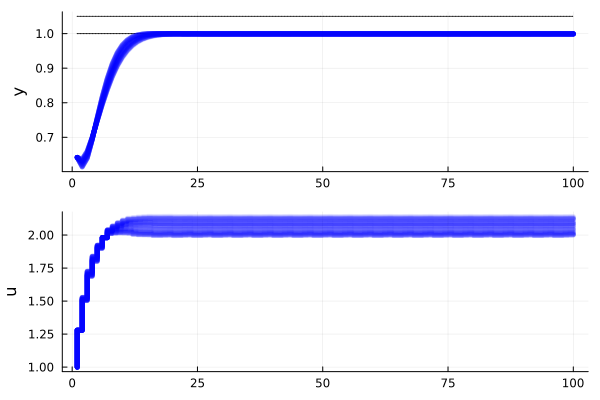

In [45]:
gr()

# time series for plotting
ts_ol = Vector{Float64}(undef,nsim) 
for ii in 1:nsim
    ts_ol[ii] = 1*ii
end

p6 = plot(ts_ol,(pUB + y0)*ones(length(ts_ol)),linestyle = :dot,linecolor = :black)
p6 = plot!(ts_ol,(pTrack + y0)*ones(length(ts_ol)),linestyle = :dot,linecolor = :black,legend=false)

for jj = 1:nMC_imp
    if jj == 1 # adding legend
        p6 = plot!(ts_ol,yPlant_ol_ms[:,jj],linewidth=5,yaxis="y",linecolor = :blue,linealpha = 0.1)
    else
        p6 = plot!(ts_ol,yPlant_ol_ms[:,jj],linewidth=5,yaxis="y",linecolor = :blue,linealpha = 0.1,legend=false)
    end
end
    
p6.series_list[1][:label] = "ytarg"
p6.series_list[2][:label] = "y"

p7 = plot(ts_ol,uPlant_ol_ms[:,1],linewidth=5,yaxis="u",linecolor = :blue,linetype=:steppre,linealpha = 0.1,legend=false)
for jj = 2:nMC_imp
    p7 = plot!(ts_ol,uPlant_ol_ms[:,jj],linewidth=5,yaxis="u",linecolor = :blue,linetype=:steppre,linealpha = 0.1,legend=false)
end

g4 = plot(p6,p7,layout=(2,1))
display(g4)
